# 相関係数についてまとめる

### 相関係数各種
- 量的変数×量的変数 -> ピアソンの積率相関係数
    - corr = Cov[X,Y] / std(X) * std(Y)
- 量的変数×質的変数 -> クラメールの連関相関係数
    - rc = root(X/ ( n(k-1) ))
- 質的変数×質的変数 -> 相関比
    - η^2 = Sb / (Sb + Sw)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [31]:
data = pd.read_csv('./data/train.csv')
pearson_coefficient(data)

/var/folders/np/chqdmqld4h98fpysyglct_4m0000gp/T/ipykernel_1944/1441673620.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return df.corr()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


# クラメール

In [32]:
def correlation_ratio(cat_key, num_key, data):

    categorical=data[cat_key]
    numerical=data[num_key]

    mean=numerical.dropna().mean()
    all_var=((numerical-mean)**2).sum()  #全体の偏差の平方和

    unique_cat=pd.Series(categorical.unique())
    unique_cat=list(unique_cat.dropna())

    categorical_num=[numerical[categorical==cat] for cat in unique_cat]
    categorical_var=[len(x.dropna())*(x.dropna().mean()-mean)**2 for x in categorical_num]  
    #カテゴリ件数×（カテゴリの平均-全体の平均）^2

    r=sum(categorical_var)/all_var

    return r

In [33]:
import scipy.stats as st

def cramerV(x, y, data):

    table=pd.crosstab(data[x], data[y])
    x2, p, dof, e=st.chi2_contingency(table, False)

    n=table.sum().sum()
    r=np.sqrt(x2/(n*(np.min(table.shape)-1)))

    return r

In [34]:
def is_categorical(data, key):

    col_type=data[key].dtype

    if col_type=='int':

        nunique=data[key].nunique()
        return nunique<6

    elif col_type=="float":
        return False

    else:
        return True

In [35]:
def get_corr(data, categorical_keys=None):

    keys=data.keys()

    if categorical_keys is None:

        categorical_keys=keys[[is_categorycal(data, key) for key in keys]]

    corr=pd.DataFrame({})
    corr_ratio=pd.DataFrame({})
    corr_cramer=pd.DataFrame({})

    for key1 in keys:
        for key2 in keys:

            if (key1 in categorical_keys) and (key2 in categorical_keys):

                r=cramerV(key1, key2, data)
                corr_cramer.loc[key1, key2]=r                

            elif (key1 in categorical_keys) and (key2 not in categorical_keys):

                r=correlation_ratio(cat_key=key1, num_key=key2, data=data)
                corr_ratio.loc[key1, key2]=r                

            elif (key1 not in categorical_keys) and (key2 in categorical_keys):

                r=correlation_ratio(cat_key=key2, num_key=key1, data=data)
                corr_ratio.loc[key1, key2]=r                

            else:

                r=data.corr().loc[key1, key2]
                corr.loc[key1, key2]=r                    

    return corr, corr_ratio, corr_cramer

### 下記３つの変数に各相関係数がはいる
- corr, corr_ratio, corr_cramer

In [36]:

test=data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
category=["Survived", "Pclass", "Sex", "Embarked"]

corr, corr_ratio, corr_cramer=get_corr(test, category)

/var/folders/np/chqdmqld4h98fpysyglct_4m0000gp/T/ipykernel_1944/4227585351.py:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  r=data.corr().loc[key1, key2]
/var/folders/np/chqdmqld4h98fpysyglct_4m0000gp/T/ipykernel_1944/4227585351.py:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  r=data.corr().loc[key1, key2]
/var/folders/np/chqdmqld4h98fpysyglct_4m0000gp/T/ipykernel_1944/4227585351.py:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  r=data.corr().loc[key1, key2]
/var/fo

In [41]:
corr

,Age,SibSp,Parch,Fare
Age,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.308247,1.000000,0.414838,0.159651
Parch,-0.189119,0.414838,1.000000,0.216225
Fare,0.096067,0.159651,0.216225,1.000000


In [42]:
corr_ratio

,Age,SibSp,Parch,Fare,Survived,Pclass,Sex,Embarked
Survived,0.005963,0.001248,0.006663,0.066207,NaN,NaN,NaN,NaN
Pclass,0.139107,0.008584,0.000348,0.353094,NaN,NaN,NaN,NaN
Sex,0.008696,0.013140,0.060265,0.033245,NaN,NaN,NaN,NaN
Age,NaN,NaN,NaN,NaN,0.005963,0.139107,0.008696,0.001795
SibSp,NaN,NaN,NaN,NaN,0.001248,0.008584,0.013140,0.004905
Parch,NaN,NaN,NaN,NaN,0.006663,0.000348,0.060265,0.007229
Fare,NaN,NaN,NaN,NaN,0.066207,0.353094,0.033245,0.079110
Embarked,0.001795,0.004905,0.007229,0.079110,NaN,NaN,NaN,NaN


In [46]:
corr_cramer

,Survived,Pclass,Sex,Embarked
Survived,1.000000,0.339817,0.543351,0.172617
Pclass,0.339817,1.000000,0.138013,0.263821
Sex,0.543351,0.138013,1.000000,0.122569
Embarked,0.172617,0.263821,0.122569,1.000000


# heatmap で表現することも可能

<AxesSubplot: >

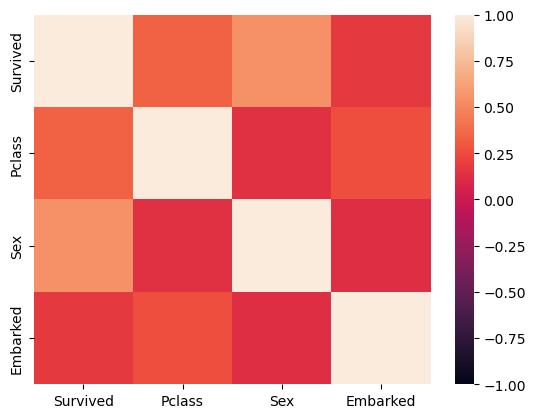

In [39]:
import seaborn as sns
sns.heatmap(corr_cramer, vmin=-1, vmax=1)

<AxesSubplot: >

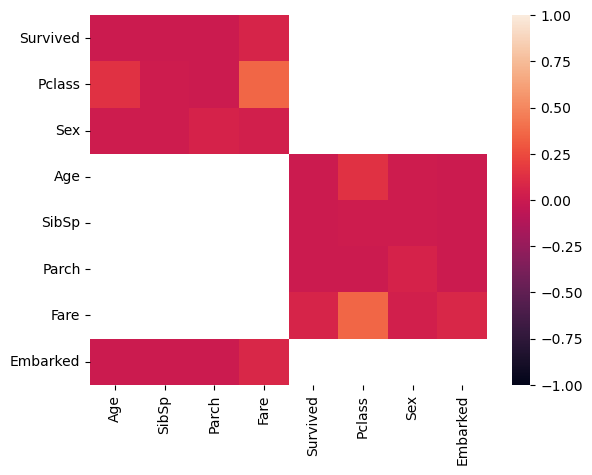

In [45]:
sns.heatmap(corr_ratio, vmin=-1, vmax=1)

<AxesSubplot: >

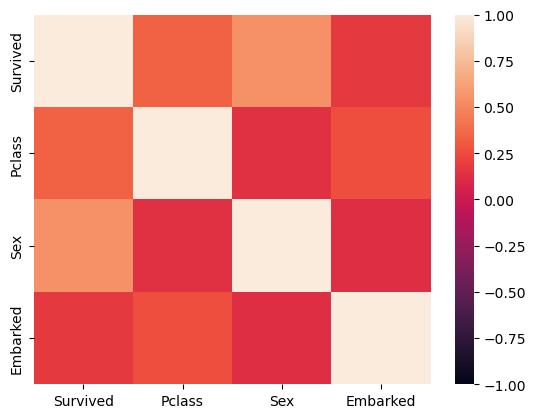

In [47]:
sns.heatmap(corr_cramer, vmax=1, vmin=-1)